In [1]:
%pylab inline
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


/home/junpenglao/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### A simplistic PyMC3 port of Bob Carpenter's [The Impact of Reparameterization on Point Estimates](http://mc-stan.org/documentation/case-studies/mle-params.html) in STAN

#### Model 1: Chance-of-Success Parameterization

In [11]:
y = np.asarray([0, 1, 0, 1, 1, 0, 0, 1, 0, 0])
N = len(y)
with pm.Model():
    # Set Transform to None so it won't use theta_log_
    theta = pm.Uniform('theta', lower=0, upper=1)
    obs = pm.Bernoulli('obs', p=theta, observed=y)
    map_est = pm.find_MAP()

map_est

logp = -6.9315, ||grad|| = 1: 100%|██████████| 6/6 [00:00<00:00, 1843.11it/s]


{'theta_interval__': array(-0.4054651), 'theta': array(0.4)}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:10<00:00, 4055.73draws/s]


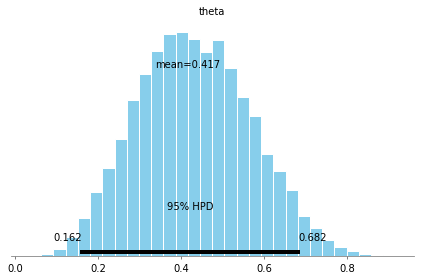

In [14]:
with pm.Model():
    # Set Transform to None so it won't use theta_log_
    theta = pm.Uniform('theta', lower=0, upper=1)
    obs = pm.Bernoulli('obs', p=theta, observed=y)
    trace = pm.sample(10000, tune=1000, njobs=4)
pm.plot_posterior(trace);

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:18<00:00, 2423.13draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


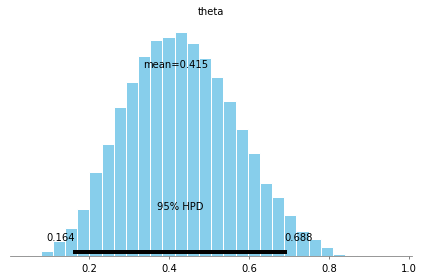

In [18]:
with pm.Model():
    # Set Transform to None so it won't use theta_log_
    theta = pm.Uniform('theta', lower=0, upper=1, transform=None)
    obs = pm.Bernoulli('obs', p=theta, observed=y)
    trace = pm.sample(10000, tune=1000, njobs=4, 
                      init='adapt_diag', 
                      nuts_kwargs={'target_accept':.99})
pm.plot_posterior(trace);

#### Model 2: Log Odds Parameterization without Jacobian

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:10<00:00, 4150.77draws/s]


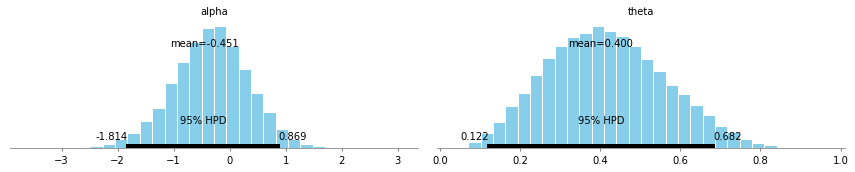

In [19]:
with pm.Model():
    alpha = pm.Flat('alpha')
    theta = pm.Deterministic('theta', pm.math.invlogit(alpha))
    obs = pm.Bernoulli('obs', p=theta, observed=y)
    trace = pm.sample(10000, tune=1000, njobs=4)
pm.plot_posterior(trace);

#### Model 3: Log Odds with Jacobian Adjustment

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:11<00:00, 3736.72draws/s]


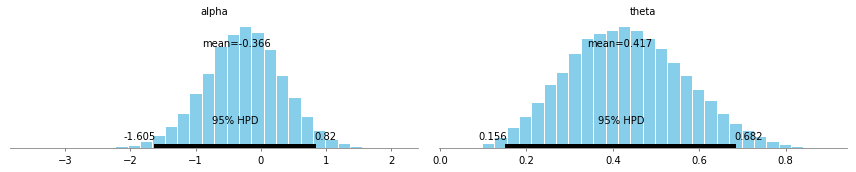

In [20]:
with pm.Model():
    alpha = pm.Flat('alpha')
    theta = pm.Deterministic('theta', pm.math.invlogit(alpha))
    
    def logp(value):
        return tt.sum(tt.sum(pm.Bernoulli.dist(p=theta).logp(value)) + \
                      tt.log(theta) + 
                      tt.log(1-theta))
    obs = pm.DensityDist('obs', logp, observed=y)
    
    trace = pm.sample(10000, tune=1000, njobs=4)
pm.plot_posterior(trace);

#### Model 3.1: Jacobian Adjustment using `pm.Potential`
`pm.Potential` is the `increment_log_prob` equivalent in PyMC3

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:11<00:00, 3817.41draws/s]


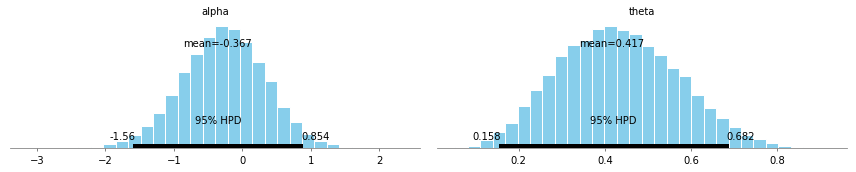

In [21]:
with pm.Model():
    alpha = pm.Flat('alpha')
    theta = pm.Deterministic('theta', pm.math.invlogit(alpha))
    obs = pm.Bernoulli('obs', p=theta, observed=y)
    constrain = pm.Potential('constrain', tt.log(theta)+tt.log(1-theta))
    trace = pm.sample(10000, tune=1000, njobs=4)
pm.plot_posterior(trace);